In [ ]:
# ============================
# Cell 1: Imports & Config
# ============================
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# LLM client (optional)
os.environ["OPENAI_API_KEY"] = "sk-"
try:
    from openai import OpenAI
    client = OpenAI()   # needs OPENAI_API_KEY in env
except Exception:
    client = None
    print("⚠️ OpenAI client not initialised – LLM steps will use fallback.")


In [2]:
# ============================
# Cell 2: Load Data
# ============================
DATA_PATH = r"C:\Users\CYJ\Downloads\preprocessed_data.csv"   # adjust if needed

df = pd.read_csv(DATA_PATH)

target_col = "Q274: How many children do you have"

# numeric-only and drop rows where target is missing
num_df = df.select_dtypes(include=[np.number]).dropna(subset=[target_col]).reset_index(drop=True)

print("Data shape (numeric, target not null):", num_df.shape)
display(num_df.head())


Data shape (numeric, target not null): (2012, 287)


,N_REGION_ISO: Region ISO 3166-2,Q1: Important in life: Family,Q2: Important in life: Friends,Q3: Important in life: Leisure time,Q4: Important in life: Politics,Q5: Important in life: Work,Q6: Important in life: Religion,Q7: Important child qualities: good manners,Q8: Important child qualities: independence,Q9: Important child qualities: hard work,...,Q283: Respondent's Father - Occupational group (when respondent was 14 years old),Q284: Sector of employment,Q285: Are you the chief wage earner in your house,Q286: Family savings during past year,Q287: Social class (subjective),Q288: Scale of incomes,Q289: Religious denominations - major groups,Q290: Ethnic group,O1_LONGITUDE: Geographical Coordinates - Longitude,O2_LATITUDE: Geographical Coordinates - Latitude
0,702001.0,1.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,...,3.0,2.0,2.0,1.0,2.0,5.0,0.0,702004.0,103.82,1.23
1,702001.0,1.0,2.0,1.0,3.0,3.0,2.0,1.0,2.0,1.0,...,4.0,2.0,1.0,2.0,4.0,1.0,0.0,702004.0,103.81,1.23
2,702001.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,...,7.0,2.0,1.0,1.0,4.0,4.0,0.0,702004.0,103.84,1.22
3,702001.0,1.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0,...,1.0,2.0,2.0,1.0,3.0,6.0,0.0,702004.0,103.84,1.22
4,702001.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,...,5.0,2.0,2.0,1.0,2.0,8.0,5.0,702003.0,103.84,1.23


FEATURE TYPE ANALYSIS

Feature Type Distribution:
  binary                   :  40 features
  categorical              :   2 features
  numerical_continuous     :   2 features
  numerical_discrete       :   5 features
  ordinal                  : 237 features

Categorical features identified: 2
  - Q289: Religious denominations - major groups
  - Q290: Ethnic group
  Note: These will be excluded from correlation heatmap

FEATURE-TARGET CORRELATION (Spearman)

Top 20 Features by Correlation with Target:


,feature,corr_with_target,feature_type
0,Q262: Age,0.485587,numerical_discrete
1,Q282: Respondent's Spouse - Occupational group,0.393980,ordinal
2,Q280: Employment status - Respondent's Spouse,0.329714,ordinal
3,Q36: Homosexual couples are as good parents as...,0.251559,ordinal
4,Q270: Number of people in household,0.243881,ordinal
5,Q218: Political actions online: Signing an ele...,0.238807,ordinal
6,Q209: Political action: Signing a petition,0.234556,ordinal
7,Q206: Information source: Internet,0.233590,ordinal
8,Q217: Political actions online: Searching info...,0.209352,ordinal
9,"Q163: The world is better off, or worse off, b...",0.207090,ordinal



Bottom 20 Features by Correlation with Target:


,feature,corr_with_target,feature_type
266,Q191: Justifiable: Violence against other people,-0.215084,ordinal
267,Q194: Justifiable: Political violence,-0.215868,ordinal
268,Q188: Justifiable: Euthanasia,-0.219472,ordinal
269,Q278: Highest educational level: Respondent's ...,-0.222526,ordinal
270,Q33: Jobs scarce: Men should have more right t...,-0.258789,ordinal
271,Q277: Highest educational level: Respondent's ...,-0.267347,ordinal
272,Q275: Highest educational level: Respondent [I...,-0.276204,ordinal
273,Q37: Duty towards society to have children,-0.290675,ordinal
274,Q202: Information source: TV news,-0.294295,ordinal
275,Q185: Justifiable: Divorce,-0.309390,ordinal



MULTICOLLINEARITY ANALYSIS

Analyzing 284 non-categorical features
Excluded 2 categorical features from correlation matrix

Using Spearman correlation (rank-based method)
  ✓ Appropriate for ordinal data (majority of features)
  ✓ Handles non-linear monotonic relationships
  ✓ Robust to outliers and non-normal distributions


C:\Users\CYJ\AppData\Local\Temp\ipykernel_11244\466245649.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


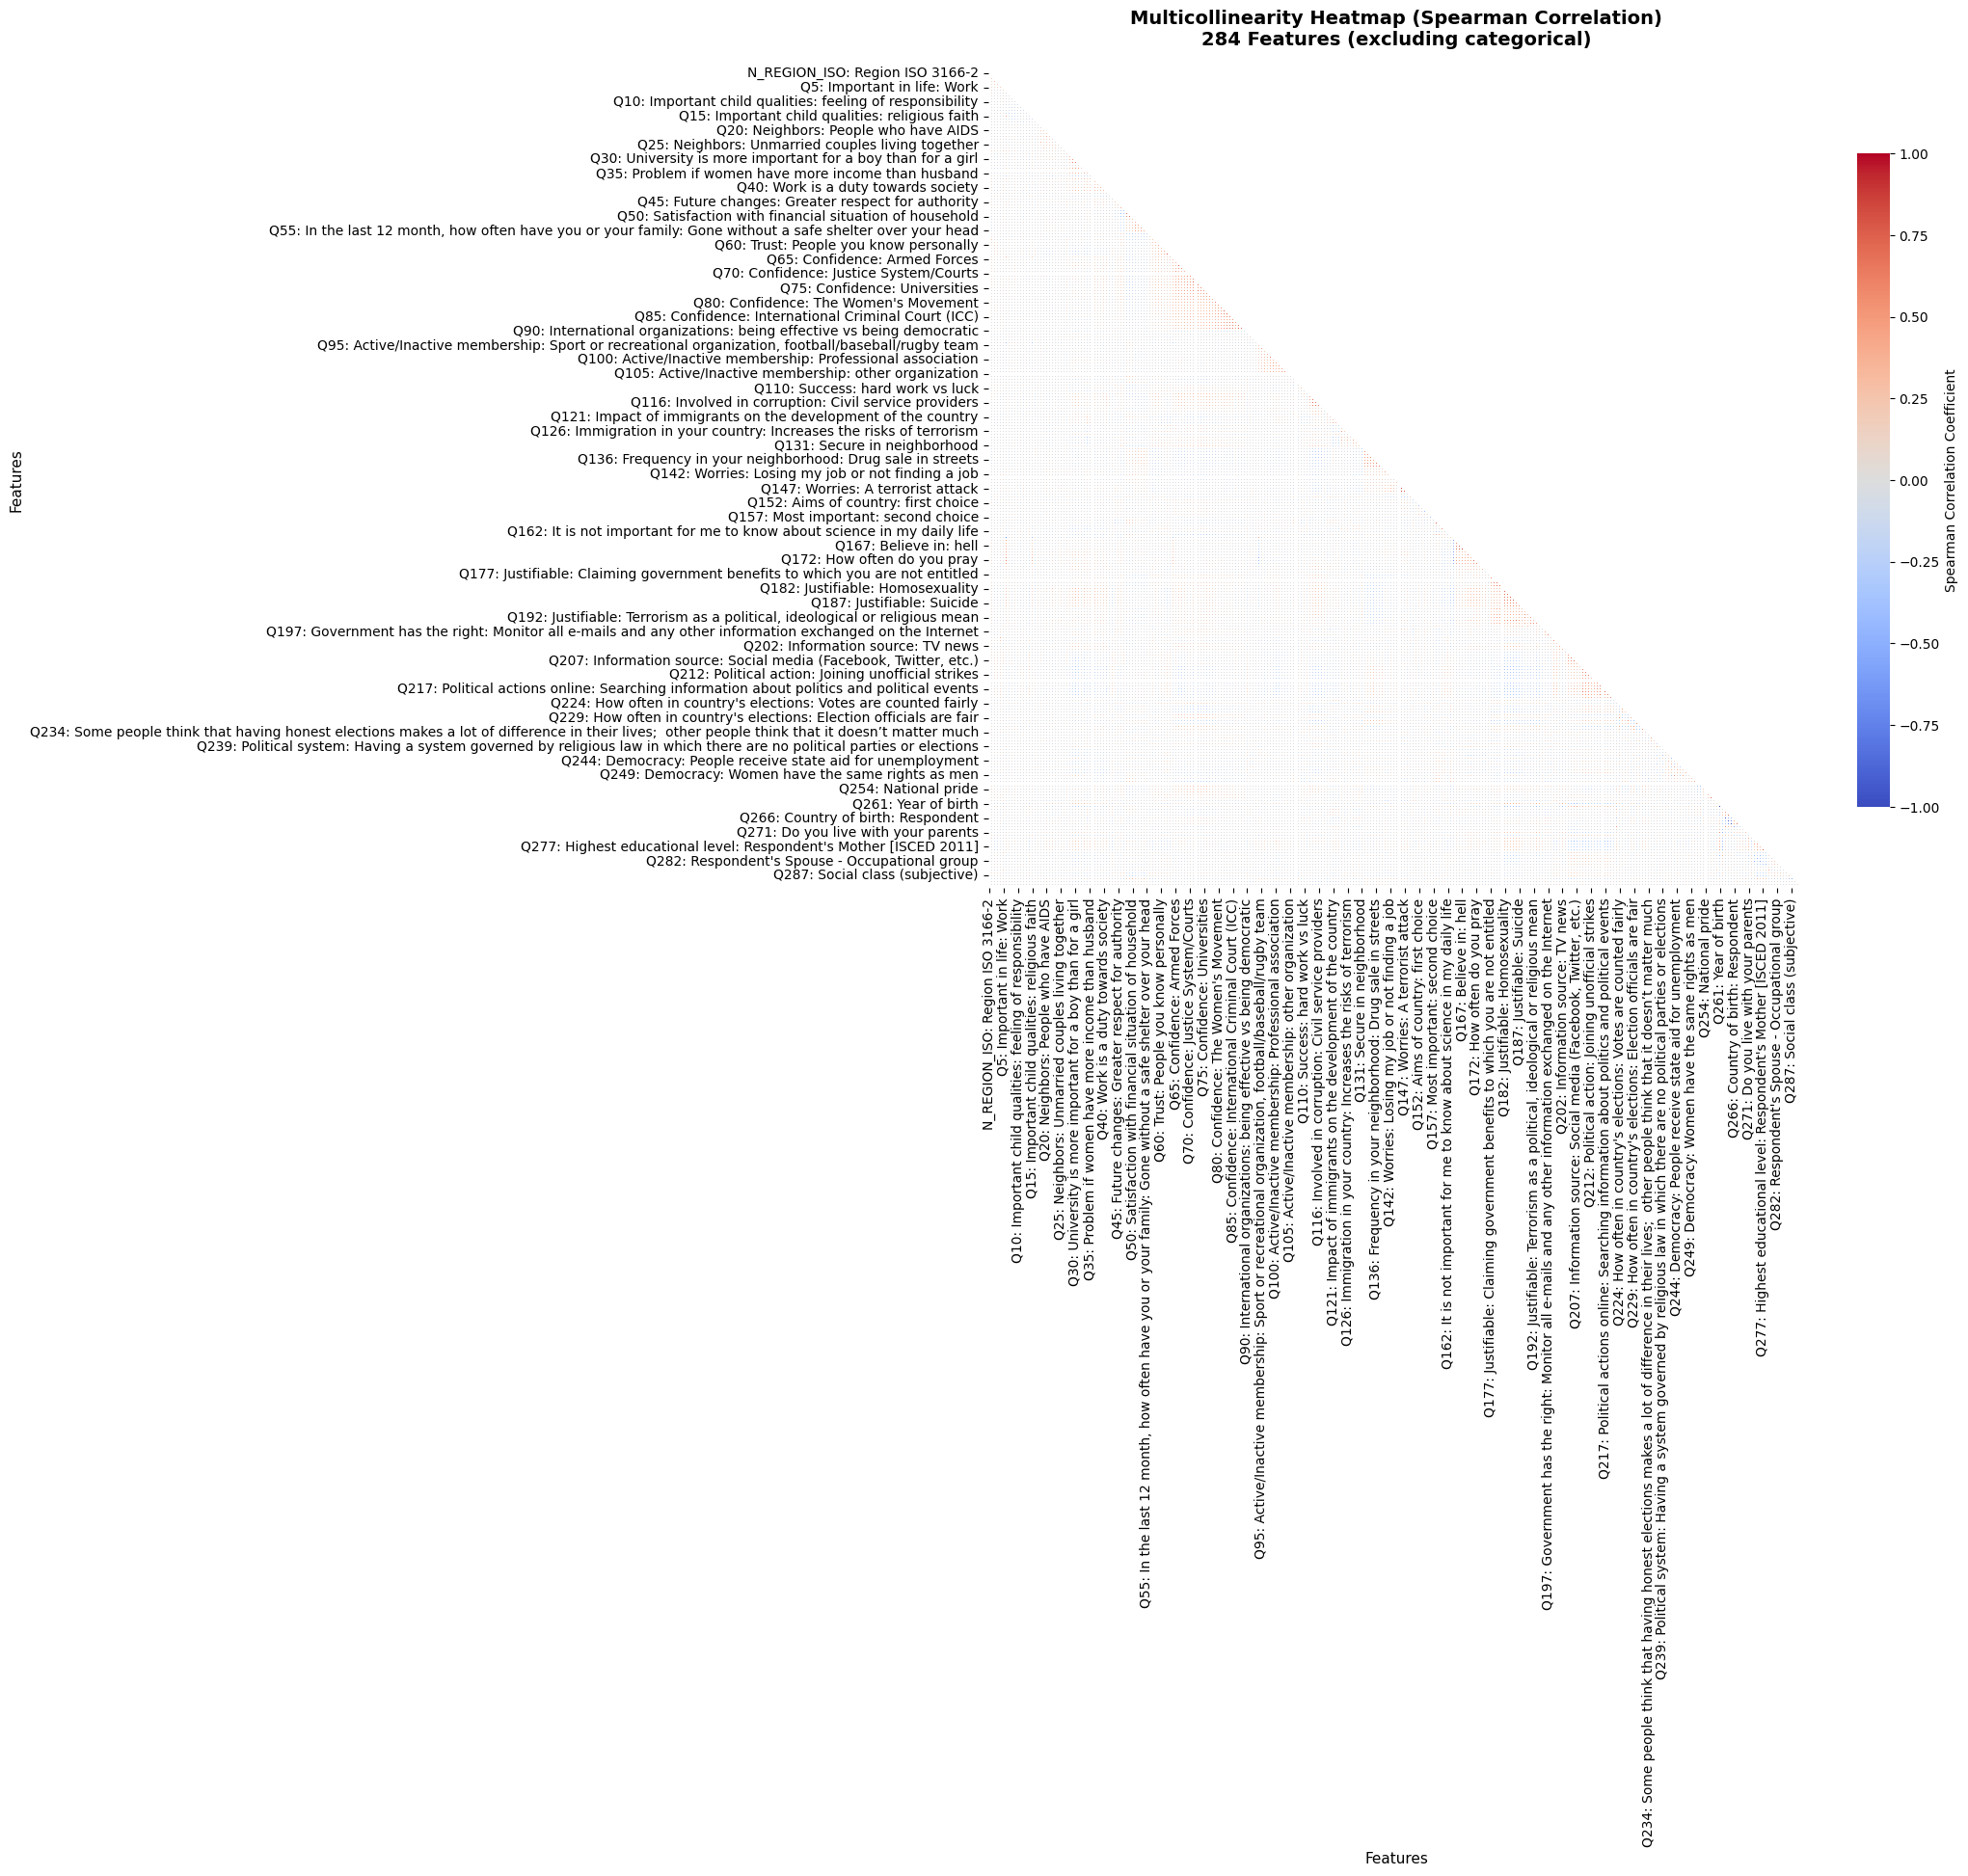


MULTICOLLINEARITY STATISTICS

High Correlations Found (|r| >= 0.7): 27

Top 20 Feature Pairs with Highest Multicollinearity:


,feature_1,feature_2,correlation,abs_correlation
22,Q261: Year of birth,Q262: Age,-0.999537,0.999537
25,Q265: Father immigrant,Q268: Country of birth: Father of the respondent,-0.963155,0.963155
23,Q263: Respondent immigrant,Q266: Country of birth: Respondent,-0.957946,0.957946
24,Q264: Mother immigrant,Q267: Country of birth: Mother of the respondent,-0.949400,0.949400
14,Q167: Believe in: hell,Q168: Believe in: heaven,0.869633,0.869633
9,Q146: Worries: A war involving my country,Q147: Worries: A terrorist attack,0.846315,0.846315
10,Q146: Worries: A war involving my country,Q148: Worries: A civil war,0.830545,0.830545
11,Q147: Worries: A terrorist attack,Q148: Worries: A civil war,0.783159,0.783159
1,Q66: Confidence: The Press,Q67: Confidence: Television,0.765262,0.765262
2,Q71: Confidence: The Government,Q73: Confidence: Parliament,0.755728,0.755728



⚠️  Warning: 27 feature pairs show high correlation (>= 0.7)
   This indicates potential multicollinearity issues.
   Consider feature selection or regularization (Ridge, Lasso, ElasticNet).

CORRELATION SUMMARY
Average absolute correlation between features: 0.071
Median absolute correlation: 0.050
Max absolute correlation: 1.000
Percentage of pairs with |r| > 0.5: 0.5%
Percentage of pairs with |r| > 0.7: 0.1%

CATEGORICAL FEATURES - SEPARATE ANALYSIS

The following 2 categorical feature(s) were excluded from
the correlation heatmap because Spearman correlation is not appropriate for
nominal categorical data:

  • Q289: Religious denominations - major groups
    - 8 categories
    - Distribution: {7.0: np.int64(525), 0.0: np.int64(472), 2.0: np.int64(347), 5.0: np.int64(275), 9.0: np.int64(154)}
    - Spearman correlation with target: 0.101 (note: may not be fully appropriate)

  • Q290: Ethnic group
    - 6 categories
    - Distribution: {702004.0: np.int64(1549), 702006.0: np.int64(

In [3]:
# ============================
# Cell 2: Feature Correlation & Multicollinearity Heatmap
# ============================

print("="*70)
print("FEATURE TYPE ANALYSIS")
print("="*70)

# Identify feature types based on unique values and naming patterns
def identify_feature_type(col_name, series):
    """Classify features into types for appropriate correlation analysis"""
    n_unique = series.nunique()
    
    # Continuous numerical (coordinates)
    if 'LONGITUDE' in col_name or 'LATITUDE' in col_name:
        return 'numerical_continuous'
    
    # Binary features (2 unique values)
    if n_unique == 2:
        return 'binary'
    
    # Categorical features (ethnic group, religious denominations)
    if 'Q289' in col_name or 'Q290' in col_name or 'Ethnic' in col_name or 'denomination' in col_name:
        return 'categorical'
    
    # Ordinal features (rating scales)
    if n_unique <= 20:
        return 'ordinal'
    
    # Numerical discrete (age, year of birth, etc.)
    return 'numerical_discrete'

# Classify features
feature_cols_all = [c for c in num_df.columns if c != target_col]
feature_types = {}
for col in feature_cols_all:
    feature_types[col] = identify_feature_type(col, num_df[col])

# Count by type
type_counts = {}
for ftype in feature_types.values():
    type_counts[ftype] = type_counts.get(ftype, 0) + 1

print("\nFeature Type Distribution:")
for ftype, count in sorted(type_counts.items()):
    print(f"  {ftype:25s}: {count:3d} features")

# Identify categorical features that need special handling
categorical_features = [col for col, ftype in feature_types.items() if ftype == 'categorical']
if categorical_features:
    print(f"\nCategorical features identified: {len(categorical_features)}")
    for cat_feat in categorical_features:
        print(f"  - {cat_feat}")
    print("  Note: These will be excluded from correlation heatmap")

# ============================
# Feature-Target Correlation Analysis
# ============================

print("\n" + "="*70)
print("FEATURE-TARGET CORRELATION (Spearman)")
print("="*70)

# Use Spearman correlation for ordinal/non-normal data
corr_to_target = num_df[feature_cols_all + [target_col]].corr(method='spearman')[target_col].sort_values(ascending=False)

corr_table = (
    corr_to_target
    .drop(labels=[target_col])
    .reset_index()
    .rename(columns={"index": "feature", target_col: "corr_with_target"})
)

# Add feature type to correlation table
corr_table['feature_type'] = corr_table['feature'].map(feature_types)

print("\nTop 20 Features by Correlation with Target:")
display(corr_table.head(20))

print("\nBottom 20 Features by Correlation with Target:")
display(corr_table.tail(20))

# ============================
# Multicollinearity Heatmap with Proper Feature Handling
# ============================

print("\n" + "="*70)
print("MULTICOLLINEARITY ANALYSIS")
print("="*70)

# Exclude categorical features from correlation matrix
non_categorical_features = [col for col in feature_cols_all if feature_types[col] != 'categorical']
print(f"\nAnalyzing {len(non_categorical_features)} non-categorical features")
print(f"Excluded {len(categorical_features)} categorical features from correlation matrix")

# Prepare data for correlation
heat_df = num_df[non_categorical_features + [target_col]]

# Use Spearman correlation for ordinal/ordinal data
# Spearman is rank-based and appropriate for:
# - Ordinal scales (most survey questions)
# - Binary variables
# - Numerical data
# - Non-normally distributed data
print("\nUsing Spearman correlation (rank-based method)")
print("  ✓ Appropriate for ordinal data (majority of features)")
print("  ✓ Handles non-linear monotonic relationships")
print("  ✓ Robust to outliers and non-normal distributions")

corr_matrix = heat_df.corr(method='spearman')

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap
plt.figure(figsize=(14, 11))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.1,
    square=True,
    cbar_kws={"label": "Spearman Correlation Coefficient", "shrink": 0.8},
    vmin=-1, vmax=1
)
plt.title(f"Multicollinearity Heatmap (Spearman Correlation)\n{len(non_categorical_features)} Features (excluding categorical)", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Features", fontsize=11)
plt.ylabel("Features", fontsize=11)
plt.tight_layout()
plt.show()

# ============================
# Multicollinearity Statistics
# ============================

print("\n" + "="*70)
print("MULTICOLLINEARITY STATISTICS")
print("="*70)

# Find high correlations (excluding diagonal and target column)
high_corr_threshold = 0.7
high_corrs = []

for i in range(len(corr_matrix.columns)-1):  # Exclude target column
    for j in range(i+1, len(corr_matrix.columns)-1):  # Upper triangle only, exclude target
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        
        if abs(corr_val) >= high_corr_threshold:
            high_corrs.append({
                'feature_1': col_i,
                'feature_2': col_j,
                'correlation': corr_val,
                'abs_correlation': abs(corr_val)
            })

if high_corrs:
    high_corr_df = pd.DataFrame(high_corrs).sort_values('abs_correlation', ascending=False)
    print(f"\nHigh Correlations Found (|r| >= {high_corr_threshold}): {len(high_corr_df)}")
    print("\nTop 20 Feature Pairs with Highest Multicollinearity:")
    display(high_corr_df.head(20))
    
    print(f"\n⚠️  Warning: {len(high_corr_df)} feature pairs show high correlation (>= {high_corr_threshold})")
    print("   This indicates potential multicollinearity issues.")
    print("   Consider feature selection or regularization (Ridge, Lasso, ElasticNet).")
else:
    print(f"\n✓ No high correlations found (|r| >= {high_corr_threshold})")
    print("  Multicollinearity is not a major concern for this dataset.")

# Summary statistics
print("\n" + "="*70)
print("CORRELATION SUMMARY")
print("="*70)

# Calculate average absolute correlation (excluding diagonal)
corr_values = []
for i in range(len(corr_matrix)-1):  # Exclude target
    for j in range(i+1, len(corr_matrix)-1):
        corr_values.append(abs(corr_matrix.iloc[i, j]))

if corr_values:
    print(f"Average absolute correlation between features: {np.mean(corr_values):.3f}")
    print(f"Median absolute correlation: {np.median(corr_values):.3f}")
    print(f"Max absolute correlation: {np.max(corr_values):.3f}")
    print(f"Percentage of pairs with |r| > 0.5: {(np.array(corr_values) > 0.5).sum() / len(corr_values) * 100:.1f}%")
    print(f"Percentage of pairs with |r| > 0.7: {(np.array(corr_values) > 0.7).sum() / len(corr_values) * 100:.1f}%")

# ============================
# Special Note on Categorical Features
# ============================

if categorical_features:
    print("\n" + "="*70)
    print("CATEGORICAL FEATURES - SEPARATE ANALYSIS")
    print("="*70)
    
    print(f"\nThe following {len(categorical_features)} categorical feature(s) were excluded from")
    print("the correlation heatmap because Spearman correlation is not appropriate for")
    print("nominal categorical data:")
    
    for cat_feat in categorical_features:
        n_categories = num_df[cat_feat].nunique()
        print(f"\n  • {cat_feat}")
        print(f"    - {n_categories} categories")
        print(f"    - Distribution: {dict(num_df[cat_feat].value_counts().head(5))}")
        
        # Show correlation with target using point-biserial or other appropriate method
        # For simplicity, we can still look at it but note the limitation
        target_corr = num_df[[cat_feat, target_col]].corr(method='spearman').iloc[0, 1]
        print(f"    - Spearman correlation with target: {target_corr:.3f} (note: may not be fully appropriate)")
    
    print("\n  Recommendation: For categorical features, consider:")
    print("    - One-hot encoding for modeling")
    print("    - Cramér's V for categorical-categorical associations")
    print("    - ANOVA for categorical-numerical associations")


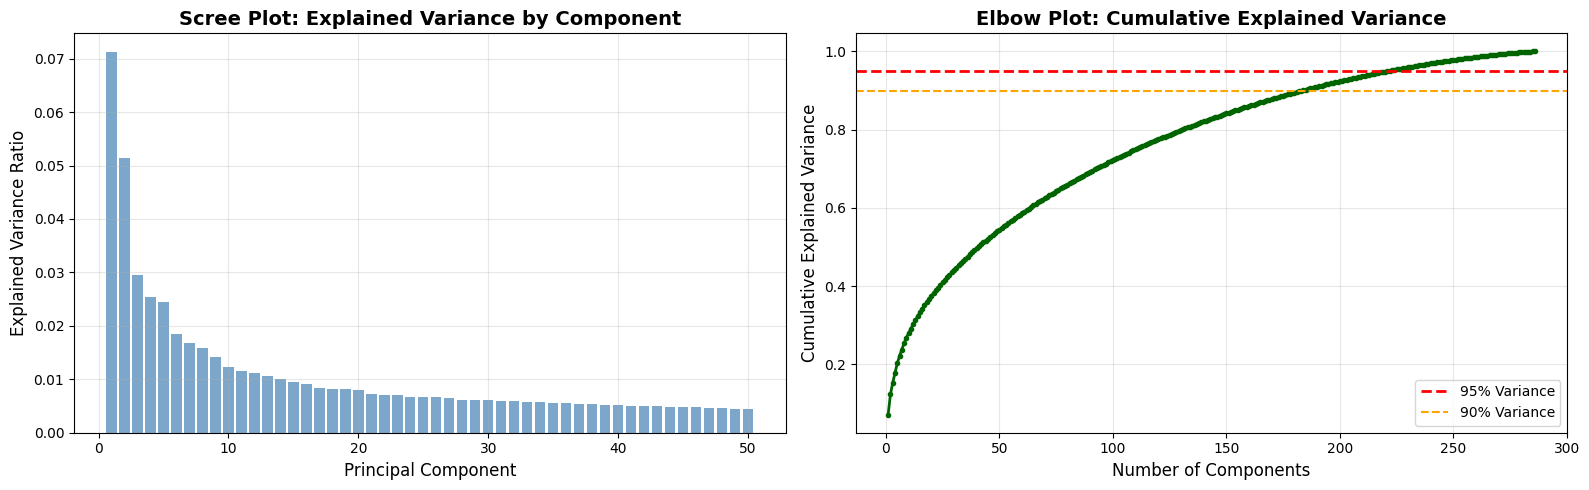


=== Components needed for variance thresholds ===
Components needed for 80% variance: 131
Components needed for 90% variance: 184
Components needed for 95% variance: 222
Components needed for 99% variance: 266

=== PCA Summary ===
- Original feature count: 286
- PCA components retained (95% variance): 222
- Total explained variance: 0.9510

=== Silhouette Analysis for K-Means Clustering on PCA Components ===
K=2: Silhouette Score = 0.0581
K=3: Silhouette Score = 0.0427
K=4: Silhouette Score = 0.0206
K=5: Silhouette Score = 0.0035
K=6: Silhouette Score = 0.0058
K=7: Silhouette Score = -0.0062
K=8: Silhouette Score = -0.0027
K=9: Silhouette Score = -0.0002
K=10: Silhouette Score = 0.0008


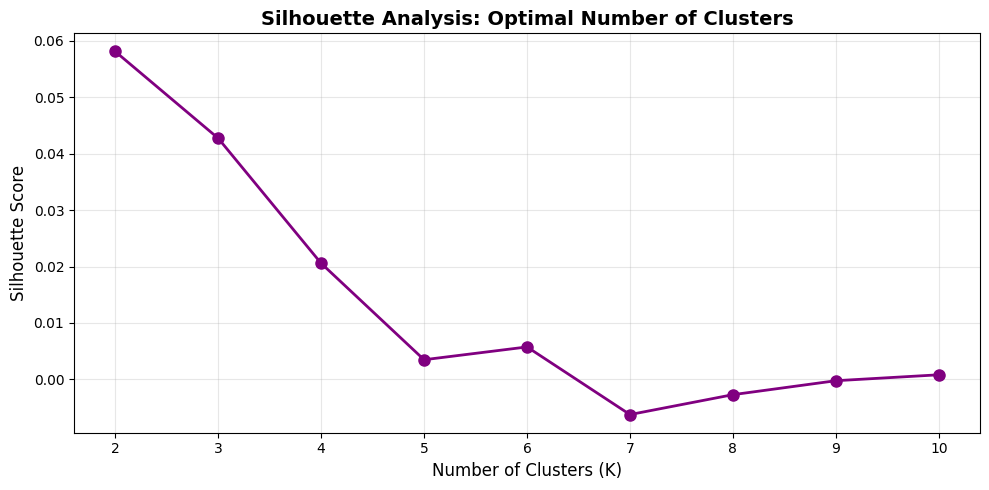


=== PCA Component Variance Table ===


,component,explained_variance,cumulative_explained_variance
0,1,0.071175,0.071175
1,2,0.051492,0.122667
2,3,0.029508,0.152175
3,4,0.025479,0.177654
4,5,0.024392,0.202046
5,6,0.018558,0.220603
6,7,0.016825,0.237428
7,8,0.015894,0.253322
8,9,0.014139,0.267462
9,10,0.012239,0.279701


In [4]:
# ============================
# Cell 3: PCA with Elbow & Silhouette Analysis
# ============================

# Get feature columns (excluding target)
feature_cols_all = [c for c in num_df.columns if c != target_col]
X_all = num_df[feature_cols_all].copy()

# Standardize features
scaler_pca = StandardScaler()
X_all_std = scaler_pca.fit_transform(X_all)

# First, fit PCA with all components to visualize
pca_full = PCA(random_state=42)
pca_full.fit(X_all_std)

# ============================
# PCA VISUALIZATION: ELBOW PLOTS
# ============================

# Plot 1: Scree Plot (Explained Variance per Component)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot - individual explained variance
n_components_to_show = min(50, len(pca_full.explained_variance_ratio_))
axes[0].bar(
    range(1, n_components_to_show + 1),
    pca_full.explained_variance_ratio_[:n_components_to_show],
    alpha=0.7,
    color='steelblue'
)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Explained Variance by Component', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative explained variance (Elbow curve)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    markersize=3,
    linewidth=2,
    color='darkgreen'
)
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90% Variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Elbow Plot: Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for different variance thresholds
print("\n=== Components needed for variance thresholds ===")
for threshold in [0.80, 0.90, 0.95, 0.99]:
    n_comp = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold*100:.0f}% variance: {n_comp}")

# Now apply PCA with 95% variance threshold
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_all_std)

print("\n=== PCA Summary ===")
print(f"- Original feature count: {len(feature_cols_all)}")
print(f"- PCA components retained (95% variance): {pca.n_components_}")
print(f"- Total explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# ============================
# SILHOUETTE ANALYSIS (Optional Clustering on PCA Components)
# ============================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Test different numbers of clusters
silhouette_scores = []
K_range = range(2, 11)

print("\n=== Silhouette Analysis for K-Means Clustering on PCA Components ===")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='purple')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis: Optimal Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()


# Show cumulative variance table
cum_var = np.cumsum(pca.explained_variance_ratio_)
pca_var_df = pd.DataFrame({
    "component": np.arange(1, len(cum_var) + 1),
    "explained_variance": pca.explained_variance_ratio_,
    "cumulative_explained_variance": cum_var
})
print("\n=== PCA Component Variance Table ===")
display(pca_var_df.head(15))

# NOTE:
# - later cells will use X_pca for modeling


In [5]:
# ============================
# Cell 4: Prepare Data for Cross-Validation
# ============================

# Use the original preprocessed features
feature_cols_all = [c for c in num_df.columns if c != target_col]
X = num_df[feature_cols_all].copy()
y = num_df[target_col].copy()

# Store feature names for later use in feature importance analysis
feature_names = feature_cols_all.copy()

print(f"Using {len(feature_cols_all)} original features for modeling")
print(f"Dataset shape: {X.shape}")

# Standardize the features
# Note: Cross-validation will handle train/test splitting internally
# StandardScaler will be applied within each fold to prevent data leakage
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✓ Features standardized using StandardScaler")
print(f"✓ Feature names stored for importance analysis")
print(f"✓ Ready for 5-fold cross-validation")
print(f"\nNote: Cross-validation will split data into 5 folds")
print(f"      Each fold will be used as validation once while training on the other 4")


Using 286 original features for modeling
Dataset shape: (2012, 286)

✓ Features standardized using StandardScaler
✓ Feature names stored for importance analysis
✓ Ready for 5-fold cross-validation

Note: Cross-validation will split data into 5 folds
      Each fold will be used as validation once while training on the other 4


In [6]:
# ============================
# Cell 5: Cross-Validation Evaluation Helper
# ============================
from sklearn.model_selection import cross_validate, cross_val_score
import numpy as np

def adjusted_r2(r2, n, k):
    """Calculate adjusted R-squared"""
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def evaluate_with_cv(name, model, X, y, cv=5):
    """
    Evaluate model using k-fold cross-validation
    
    Parameters:
    -----------
    name : str
        Model name
    model : sklearn estimator
        Fitted model to evaluate
    X : array-like
        Features
    y : array-like
        Target variable
    cv : int
        Number of cross-validation folds (default=5)
    
    Returns:
    --------
    metrics : dict
        Dictionary containing cross-validation metrics
    """
    # Perform cross-validation with multiple metrics
    scoring = {
        'r2': 'r2',
        'neg_mse': 'neg_mean_squared_error',
        'neg_mae': 'neg_mean_absolute_error'
    }
    
    cv_results = cross_validate(
        model, X, y, 
        cv=cv, 
        scoring=scoring,
        return_train_score=True
    )
    
    # Calculate mean and std for each metric
    n_samples = len(y)
    n_features = X.shape[1]
    
    metrics = {
        "model": name,
        
        # Training scores
        "train_r2_mean": cv_results['train_r2'].mean(),
        "train_r2_std": cv_results['train_r2'].std(),
        
        # Validation scores
        "cv_r2_mean": cv_results['test_r2'].mean(),
        "cv_r2_std": cv_results['test_r2'].std(),
        
        # RMSE
        "cv_rmse_mean": np.sqrt(-cv_results['test_neg_mse'].mean()),
        "cv_rmse_std": np.sqrt(cv_results['test_neg_mse'].var()),
        
        # MAE
        "cv_mae_mean": -cv_results['test_neg_mae'].mean(),
        "cv_mae_std": cv_results['test_neg_mae'].std(),
        
        # Adjusted R2 (approximate using mean validation R2)
        "cv_adjr2_mean": adjusted_r2(
            cv_results['test_r2'].mean(), 
            n_samples, 
            n_features
        ),
        
        # Individual fold scores for reference
        "cv_r2_folds": cv_results['test_r2'].tolist(),
    }
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Train R² (mean ± std): {metrics['train_r2_mean']:.4f} ± {metrics['train_r2_std']:.4f}")
    print(f"CV R² (mean ± std):    {metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f}")
    print(f"CV RMSE (mean ± std):  {metrics['cv_rmse_mean']:.4f} ± {metrics['cv_rmse_std']:.4f}")
    print(f"CV MAE (mean ± std):   {metrics['cv_mae_mean']:.4f} ± {metrics['cv_mae_std']:.4f}")
    print(f"CV Adj R² (mean):      {metrics['cv_adjr2_mean']:.4f}")
    print(f"\nR² scores per fold: {[f'{x:.4f}' for x in metrics['cv_r2_folds']]}")
    
    return metrics


In [7]:
# ============================
# Cell 6: LLM grid helper + fallback
# ============================
def get_fallback_grid(model_name: str):
    """
    Comprehensive hyperparameter grids for model tuning
    Expanded ranges for thorough grid search
    """
    name = model_name.lower()
    
    if "ridge" in name:
        return {
            "alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
        }
    
    if "lasso" in name:
        return {
            "alpha": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], 
            "max_iter": [5000, 10000]
        }
    
    if "elastic" in name:
        return {
            "alpha": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
            "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],
            "max_iter": [5000, 10000]
        }
    
    # No hyperparameters for basic Linear Regression
    return None

def get_llm_grid(model_name: str):
    """
    LLM-generated hyperparameter grids (with fallback)
    """
    if client is None:
        return get_fallback_grid(model_name)
    
    try:
        prompt = f"""
        For the model '{model_name}' in sklearn, return a Python dictionary 
        of hyperparameter grids suitable for GridSearchCV. 
        
        Requirements:
        - Use comprehensive ranges (10+ values for main parameters)
        - Include both small and large values
        - For Ridge: test alpha from 0.001 to 1000
        - For Lasso: test alpha from 0.0001 to 1.0, include max_iter
        - For ElasticNet: test alpha from 0.0001 to 1.0, l1_ratio from 0.1 to 0.99, include max_iter
        
        Return ONLY a valid Python dict with no extra text.
        Example format: {{"alpha": [0.001, 0.01, 0.1, 1.0, 10.0]}}
        """
        
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
        )
        txt = resp.choices[0].message.content.strip()
        grid = json.loads(txt.replace("'", '"'))
        return grid
    except Exception:
        return get_fallback_grid(model_name)


In [8]:
# ============================
# Cell 7: GridSearch with Cross-Validation
# ============================
def tune_and_evaluate(
    name,
    estimator,
    X,
    y,
    use_llm_grid=True,
    cv=5
):
    """
    Tune hyperparameters using GridSearchCV and evaluate using cross-validation
    
    Parameters:
    -----------
    name : str
        Model name
    estimator : sklearn estimator
        Model to tune and evaluate
    X : array-like
        Features
    y : array-like
        Target variable
    use_llm_grid : bool
        Whether to use LLM-generated grid (if False, uses fallback)
    cv : int
        Number of cross-validation folds (default=5)
    
    Returns:
    --------
    best_model : sklearn estimator
        Best model after hyperparameter tuning
    metrics : dict
        Dictionary containing cross-validation metrics
    """
    # Get hyperparameter grid
    if use_llm_grid:
        param_grid = get_llm_grid(name)
    else:
        param_grid = get_fallback_grid(name)

    # Perform grid search with cross-validation
    if param_grid:
        print(f"\n>>> Running GridSearchCV for {name}")
        print(f"    Hyperparameter grid: {param_grid}")
        print(f"    Cross-validation folds: {cv}")
        
        gs = GridSearchCV(
            estimator,
            param_grid=param_grid,
            cv=cv,
            scoring="r2",
            n_jobs=-1,
            verbose=0
        )
        gs.fit(X, y)
        best_model = gs.best_estimator_
        
        print(f"    Best parameters: {gs.best_params_}")
        print(f"    Best CV R² score: {gs.best_score_:.4f}")
    else:
        print(f"\n>>> No hyperparameters to tune for {name}")
        print(f"    Fitting model directly with {cv}-fold CV")
        best_model = estimator.fit(X, y)

    # Evaluate the best model using cross-validation
    metrics = evaluate_with_cv(name, best_model, X, y, cv=cv)
    
    # Add additional info
    metrics["best_params"] = gs.best_params_ if param_grid else {}
    metrics["n_features"] = X.shape[1]
    
    return best_model, metrics


In [9]:
# ============================
# Cell 8: Train All Models with 5-Fold Cross-Validation
# ============================
results = []
trained_models = {}  # Store trained models for feature importance analysis

print("="*70)
print("TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION")
print("="*70)

# 1. Linear Regression (OLS)
print("\n[1/4] Linear Regression (OLS)")
ols = LinearRegression()
ols, m_ols = tune_and_evaluate(
    "Linear Regression (OLS)",
    ols,
    X_scaled,
    y,
    use_llm_grid=False,  # OLS has no hyperparameters
    cv=5
)
results.append(m_ols)
trained_models["Linear Regression (OLS)"] = ols

# 2. Ridge Regression
print("\n[2/4] Ridge Regression")
ridge = Ridge(random_state=42)
ridge, m_ridge = tune_and_evaluate(
    "Ridge Regression",
    ridge,
    X_scaled,
    y,
    use_llm_grid=True,
    cv=5
)
results.append(m_ridge)
trained_models["Ridge Regression"] = ridge

# 3. Lasso Regression
print("\n[3/4] Lasso Regression")
lasso = Lasso(random_state=42)
lasso, m_lasso = tune_and_evaluate(
    "Lasso Regression",
    lasso,
    X_scaled,
    y,
    use_llm_grid=True,
    cv=5
)
results.append(m_lasso)
trained_models["Lasso Regression"] = lasso

# 4. ElasticNet Regression
print("\n[4/4] ElasticNet Regression")
elastic = ElasticNet(random_state=42)
elastic, m_elastic = tune_and_evaluate(
    "ElasticNet Regression",
    elastic,
    X_scaled,
    y,
    use_llm_grid=True,
    cv=5
)
results.append(m_elastic)
trained_models["ElasticNet Regression"] = elastic

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*70)
print(f"\n✓ {len(trained_models)} models stored for feature importance analysis")


TRAINING MODELS WITH 5-FOLD CROSS-VALIDATION

[1/4] Linear Regression (OLS)

>>> No hyperparameters to tune for Linear Regression (OLS)
    Fitting model directly with 5-fold CV

Model: Linear Regression (OLS)
Train R² (mean ± std): 0.6338 ± 0.0114
CV R² (mean ± std):    0.4352 ± 0.0658
CV RMSE (mean ± std):  1.0127 ± 0.1431
CV MAE (mean ± std):   0.7459 ± 0.0286
CV Adj R² (mean):      0.3415

R² scores per fold: ['0.3560', '0.3540', '0.4983', '0.4891', '0.4785']

[2/4] Ridge Regression

>>> Running GridSearchCV for Ridge Regression
    Hyperparameter grid: {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}
    Cross-validation folds: 5
    Best parameters: {'alpha': 500.0}
    Best CV R² score: 0.4905

Model: Ridge Regression
Train R² (mean ± std): 0.5999 ± 0.0106
CV R² (mean ± std):    0.4905 ± 0.0446
CV RMSE (mean ± std):  0.9614 ± 0.1009
CV MAE (mean ± std):   0.7088 ± 0.0243
CV Adj R² (mean):      0.4060

R² scores per fold: ['0.4522', '0.4228', '0.5200

In [10]:
# ============================
# Cell 9: Cross-Validation Results Table
# ============================
results_df = pd.DataFrame(results)

# Select columns to display
cols = [c for c in [
    "model",
    "train_r2_mean", "train_r2_std",
    "cv_r2_mean", "cv_r2_std",
    "cv_adjr2_mean",
    "cv_rmse_mean", "cv_rmse_std",
    "cv_mae_mean", "cv_mae_std",
    "best_params",
    "n_features",
] if c in results_df.columns]

# Display results sorted by CV R² score
print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS (sorted by CV R² mean)")
print("="*70)
display(
    results_df[cols].sort_values(by="cv_r2_mean", ascending=False).reset_index(drop=True)
)

# Summary statistics
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
best_model = results_df.loc[results_df['cv_r2_mean'].idxmax()]
print(f"Best Model: {best_model['model']}")
print(f"  CV R²: {best_model['cv_r2_mean']:.4f} ± {best_model['cv_r2_std']:.4f}")
print(f"  CV RMSE: {best_model['cv_rmse_mean']:.4f} ± {best_model['cv_rmse_std']:.4f}")
print(f"  CV MAE: {best_model['cv_mae_mean']:.4f} ± {best_model['cv_mae_std']:.4f}")
print(f"  Best Params: {best_model['best_params']}")

# Check for overfitting
print("\n" + "="*70)
print("OVERFITTING CHECK")
print("="*70)
for _, row in results_df.iterrows():
    train_r2 = row['train_r2_mean']
    cv_r2 = row['cv_r2_mean']
    diff = train_r2 - cv_r2
    
    if diff > 0.1:
        status = "⚠️  POTENTIAL OVERFITTING"
    elif diff > 0.05:
        status = "⚡ Slight overfitting"
    else:
        status = "✅ Good generalization"
    
    print(f"{row['model']:30s} | Train R²: {train_r2:.4f} | CV R²: {cv_r2:.4f} | Diff: {diff:.4f} | {status}")



CROSS-VALIDATION RESULTS (sorted by CV R² mean)


,model,train_r2_mean,train_r2_std,cv_r2_mean,cv_r2_std,cv_adjr2_mean,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std,best_params,n_features
0,ElasticNet Regression,0.546822,0.013014,0.530506,0.050701,0.452666,0.923295,0.112877,0.659859,0.035043,"{'alpha': 0.05, 'l1_ratio': 0.95, 'max_iter': ...",286
1,Lasso Regression,0.545294,0.013135,0.530379,0.050747,0.452518,0.923417,0.112926,0.659601,0.035126,"{'alpha': 0.05, 'max_iter': 5000}",286
2,Ridge Regression,0.599893,0.010575,0.490478,0.044562,0.406000,0.961402,0.100932,0.708829,0.024293,{'alpha': 500.0},286
3,Linear Regression (OLS),0.633800,0.011407,0.435166,0.065783,0.341518,1.012730,0.143081,0.745932,0.028561,{},286



SUMMARY
Best Model: ElasticNet Regression
  CV R²: 0.5305 ± 0.0507
  CV RMSE: 0.9233 ± 0.1129
  CV MAE: 0.6599 ± 0.0350
  Best Params: {'alpha': 0.05, 'l1_ratio': 0.95, 'max_iter': 5000}

OVERFITTING CHECK
Linear Regression (OLS)        | Train R²: 0.6338 | CV R²: 0.4352 | Diff: 0.1986 | ⚠️  POTENTIAL OVERFITTING
Ridge Regression               | Train R²: 0.5999 | CV R²: 0.4905 | Diff: 0.1094 | ⚠️  POTENTIAL OVERFITTING
Lasso Regression               | Train R²: 0.5453 | CV R²: 0.5304 | Diff: 0.0149 | ✅ Good generalization
ElasticNet Regression          | Train R²: 0.5468 | CV R²: 0.5305 | Diff: 0.0163 | ✅ Good generalization


RESIDUAL PLOTS FOR ALL MODELS



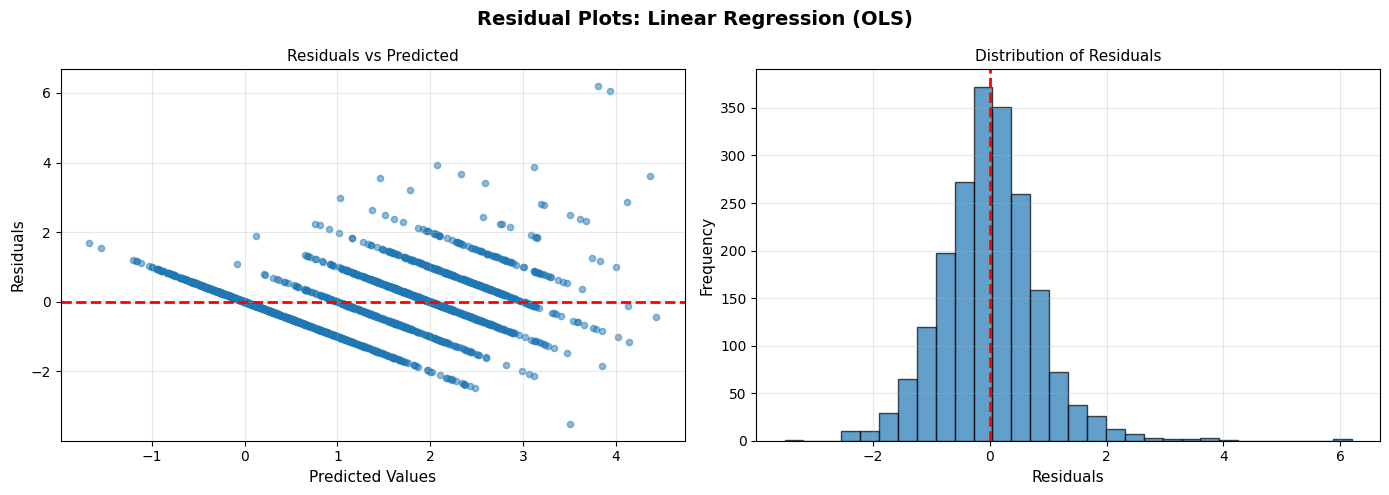

Residual Statistics for Linear Regression (OLS):
  Mean: -0.0000
  Std Dev: 0.8326
  Min: -3.5061
  Max: 6.1916



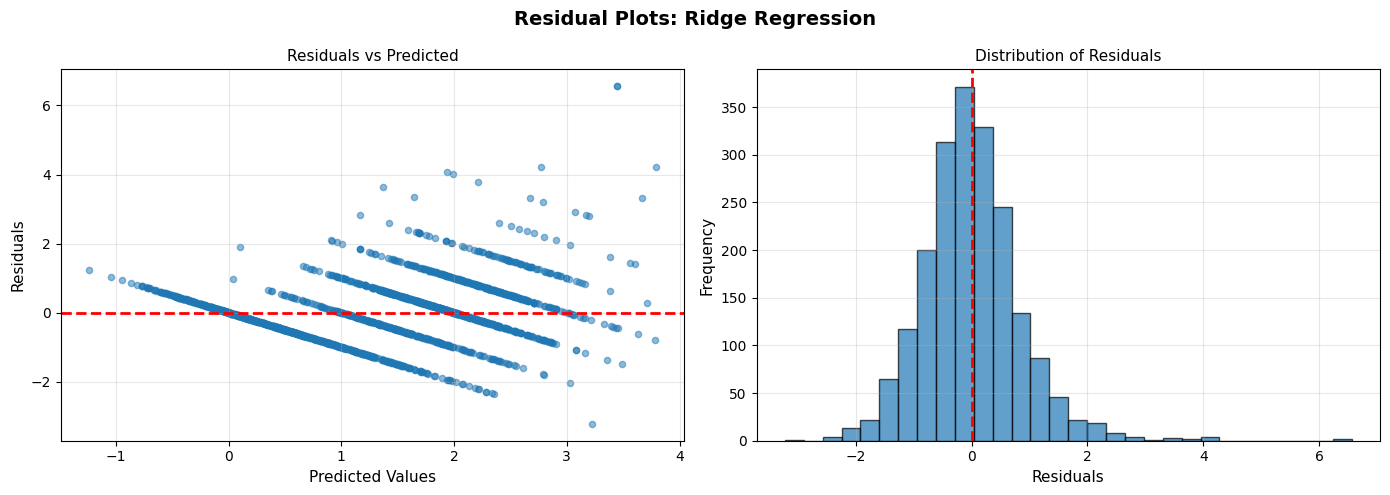

Residual Statistics for Ridge Regression:
  Mean: 0.0000
  Std Dev: 0.8577
  Min: -3.2205
  Max: 6.5570



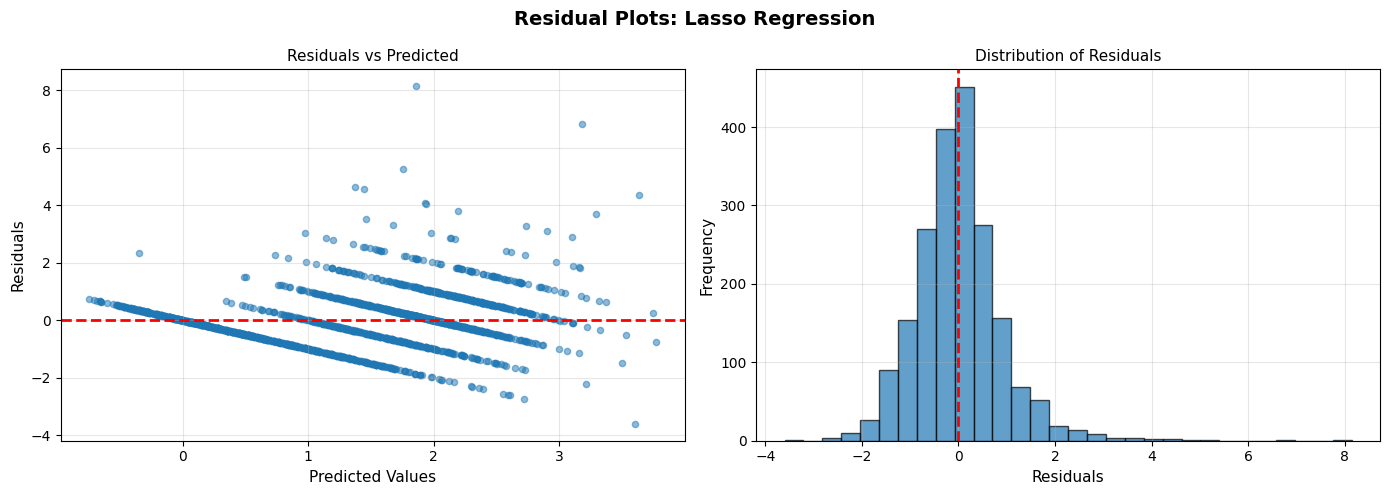

Residual Statistics for Lasso Regression:
  Mean: -0.0000
  Std Dev: 0.9121
  Min: -3.6017
  Max: 8.1395



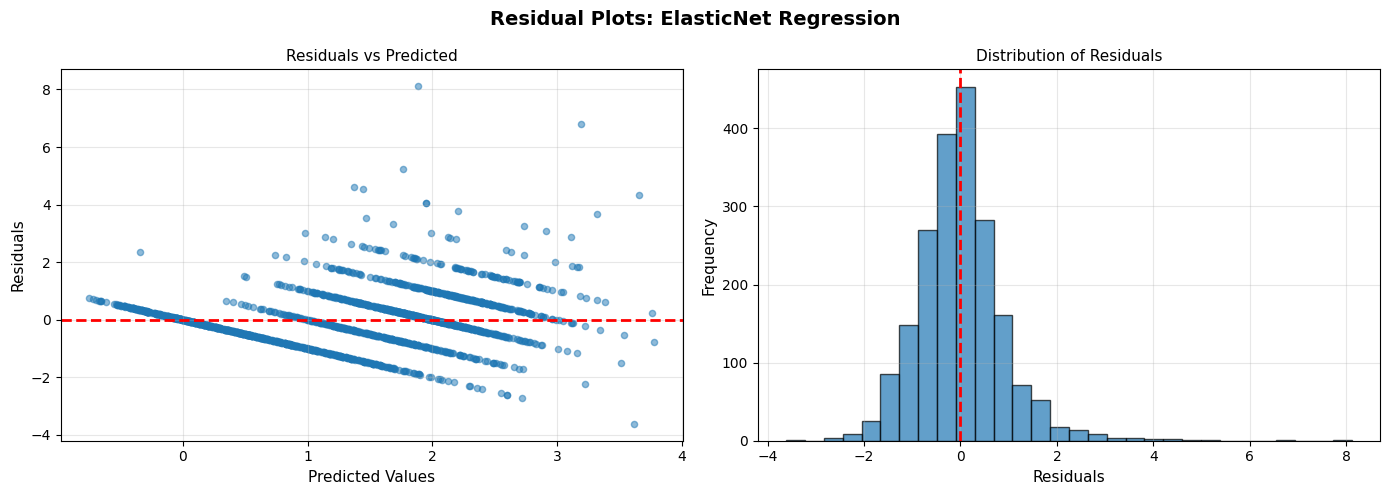

Residual Statistics for ElasticNet Regression:
  Mean: 0.0000
  Std Dev: 0.9110
  Min: -3.6139
  Max: 8.1137



In [11]:
# ============================
# Cell: Simple Residual Plots
# ============================

def plot_residuals(model, X, y, model_name):
    """
    Create simple residual plots for regression model
    """
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate residuals
    residuals = y - y_pred
    
    # Create 2 simple plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Residual Plots: {model_name}', fontsize=14, fontweight='bold')
    
    # Plot 1: Residuals vs Predicted
    axes[0].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Predicted Values', fontsize=11)
    axes[0].set_ylabel('Residuals', fontsize=11)
    axes[0].set_title('Residuals vs Predicted', fontsize=11)
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Histogram of Residuals
    axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residuals', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Distribution of Residuals', fontsize=11)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Residual Statistics for {model_name}:")
    print(f"  Mean: {residuals.mean():.4f}")
    print(f"  Std Dev: {residuals.std():.4f}")
    print(f"  Min: {residuals.min():.4f}")
    print(f"  Max: {residuals.max():.4f}")
    print()

print("="*70)
print("RESIDUAL PLOTS FOR ALL MODELS")
print("="*70)
print()

# Create residual plots for each model
for model_name, model in trained_models.items():
    plot_residuals(model, X_scaled, y, model_name)


In [12]:
# ============================
# Cell 10: Feature Importance Analysis
# ============================

# Display coefficient interpretation guide
print("="*70)
print("📚 UNDERSTANDING COEFFICIENTS IN LINEAR REGRESSION")
print("="*70)
print("""
IMPORTANT: All features have been STANDARDIZED (mean=0, std=1)

COEFFICIENT VALUE (e.g., +0.52 or -0.35):
  - Shows DIRECTION and MAGNITUDE of the relationship
  - POSITIVE (+): When feature increases by 1 SD → target increases
  - NEGATIVE (-): When feature increases by 1 SD → target decreases
  - MAGNITUDE: Size of the coefficient = strength of the effect
  
  Example: Coefficient = +0.52 for "Life Satisfaction"
  → A 1 standard deviation increase in life satisfaction 
    leads to a 0.52 standard deviation increase in the target

ABSOLUTE VALUE (e.g., 0.52 from either +0.52 or -0.52):
  - Shows IMPORTANCE regardless of direction
  - Used to RANK features by impact strength
  - Higher |coefficient| = more important feature
  - Doesn't tell you if relationship is positive or negative

WHY THIS MATTERS:
  - Features are directly comparable (all on same scale)
  - You can compare coefficients across different features
  - A coefficient of +0.5 has the same strength as -0.5 (just opposite direction)
  
NOTE: Look at BOTH values to fully understand a feature:
  → Coefficient value: What happens when feature changes
  → Absolute value: How important the feature is overall
""")
print("="*70)

def get_feature_importance(model, feature_names, model_name):
    """
    Extract feature importance from linear models based on coefficients
    
    Parameters:
    -----------
    model : sklearn estimator
        Trained linear model
    feature_names : list
        List of feature names
    model_name : str
        Name of the model
    
    Returns:
    --------
    importance_df : DataFrame
        DataFrame with features and their importance scores
    """
    # Get coefficients
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        print(f"Model {model_name} does not have coefficients")
        return None
    
    # Create DataFrame with feature names and absolute coefficient values
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    })
    
    # Sort by absolute coefficient value (importance)
    importance_df = importance_df.sort_values('abs_coefficient', ascending=False)
    
    return importance_df

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS - TOP 20 FEATURES PER MODEL")
print("="*70)

# Analyze each model
all_feature_importances = {}

for model_name, model in trained_models.items():
    print(f"\n{'='*70}")
    print(f"MODEL: {model_name}")
    print(f"{'='*70}")
    
    importance_df = get_feature_importance(model, feature_names, model_name)
    
    if importance_df is not None:
        # Store for later use
        all_feature_importances[model_name] = importance_df
        
        # Display top 20 features
        top_20 = importance_df.head(20)
        
        print(f"\nTop 20 Most Important Features (by absolute coefficient):")
        print(f"{'Rank':<6} {'Feature':<50} {'Coefficient':<15} {'|Coefficient|':<15} {'Impact':<12}")
        print("-" * 105)
        
        for idx, (_, row) in enumerate(top_20.iterrows(), 1):
            feature = row['feature']
            coef = row['coefficient']
            abs_coef = row['abs_coefficient']
            
            # Determine impact direction
            if coef > 0.001:
                impact = "↑ Positive"
            elif coef < -0.001:
                impact = "↓ Negative"
            else:
                impact = "○ Zero"
            
            # Truncate long feature names
            feature_display = feature[:47] + "..." if len(feature) > 50 else feature
            
            print(f"{idx:<6} {feature_display:<50} {coef:>14.6f} {abs_coef:>14.6f} {impact:<12}")
        
        # Show statistics
        print(f"\nCoefficient Statistics:")
        print(f"  Max absolute coefficient: {importance_df['abs_coefficient'].max():.6f}")
        print(f"  Mean absolute coefficient: {importance_df['abs_coefficient'].mean():.6f}")
        print(f"  Median absolute coefficient: {importance_df['abs_coefficient'].median():.6f}")
        print(f"  Non-zero coefficients: {(importance_df['abs_coefficient'] > 1e-10).sum()} / {len(importance_df)}")
        
        # Count positive vs negative coefficients
        n_positive = (importance_df['coefficient'] > 1e-10).sum()
        n_negative = (importance_df['coefficient'] < -1e-10).sum()
        n_zero = len(importance_df) - n_positive - n_negative
        print(f"  Positive coefficients: {n_positive}")
        print(f"  Negative coefficients: {n_negative}")
        print(f"  Near-zero coefficients: {n_zero}")

# Summary: Compare top features across models
print(f"\n{'='*70}")
print("FEATURE OVERLAP ANALYSIS")
print(f"{'='*70}")

# Get top 10 features for each model
top_features_per_model = {}
for model_name, importance_df in all_feature_importances.items():
    top_features_per_model[model_name] = set(importance_df.head(10)['feature'].tolist())

# Find common top features
if len(top_features_per_model) > 1:
    all_top_features = set.intersection(*top_features_per_model.values())
    print(f"\nFeatures in TOP 10 of ALL models ({len(all_top_features)} features):")
    if all_top_features:
        for feat in sorted(all_top_features):
            print(f"  ✓ {feat}")
            # Show coefficients across models
            for model_name, importance_df in all_feature_importances.items():
                feat_coef = importance_df[importance_df['feature'] == feat]['coefficient'].values[0]
                direction = "↑" if feat_coef > 0 else "↓"
                print(f"      {model_name:30s}: {feat_coef:>8.4f} {direction}")
    
    # Show model-specific top features
    print(f"\nModel-Specific Top Features (unique to each model):")
    for model_name, top_feats in top_features_per_model.items():
        unique_feats = top_feats - set.union(*[v for k, v in top_features_per_model.items() if k != model_name])
        if unique_feats:
            print(f"\n  {model_name}: {len(unique_feats)} unique features in top 10")
            for feat in sorted(unique_feats):
                coef = all_feature_importances[model_name][all_feature_importances[model_name]['feature'] == feat]['coefficient'].values[0]
                direction = "↑" if coef > 0 else "↓"
                print(f"    - {feat}: {coef:.4f} {direction}")

print(f"\n{'='*70}")


📚 UNDERSTANDING COEFFICIENTS IN LINEAR REGRESSION

IMPORTANT: All features have been STANDARDIZED (mean=0, std=1)

COEFFICIENT VALUE (e.g., +0.52 or -0.35):
  - Shows DIRECTION and MAGNITUDE of the relationship
  - POSITIVE (+): When feature increases by 1 SD → target increases
  - NEGATIVE (-): When feature increases by 1 SD → target decreases
  - MAGNITUDE: Size of the coefficient = strength of the effect

  Example: Coefficient = +0.52 for "Life Satisfaction"
  → A 1 standard deviation increase in life satisfaction 
    leads to a 0.52 standard deviation increase in the target

ABSOLUTE VALUE (e.g., 0.52 from either +0.52 or -0.52):
  - Shows IMPORTANCE regardless of direction
  - Used to RANK features by impact strength
  - Higher |coefficient| = more important feature
  - Doesn't tell you if relationship is positive or negative

WHY THIS MATTERS:
  - Features are directly comparable (all on same scale)
  - You can compare coefficients across different features
  - A coefficient of

In [14]:
# ============================
# Cell 11: Enhanced LLM Commentary with Feature Importance
# ============================

# Set pandas display options to show full output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def call_llm_on_results_full(results, feature_importances):
    if client is None:
        print("LLM not available — skipping commentary.")
        return
    
    # Prepare results summary - convert numpy types to native Python types
    results_clean = []
    for result in results:
        clean_result = {}
        for key, value in result.items():
            # Convert numpy types to Python native types
            if isinstance(value, (np.integer, np.int64, np.int32)):
                clean_result[key] = int(value)
            elif isinstance(value, (np.floating, np.float64, np.float32)):
                clean_result[key] = float(value)
            elif isinstance(value, list):
                # Convert list items if they're numpy types
                clean_result[key] = [float(x) if isinstance(x, (np.floating, np.float64)) else x for x in value]
            else:
                clean_result[key] = value
        results_clean.append(clean_result)
    
    results_txt = json.dumps(results_clean, indent=2)
    
    # Prepare detailed feature importance with top 20 for each model
    feature_summary = {}
    for model_name, importance_df in feature_importances.items():
        top_20 = importance_df.head(20)
        
        # Convert numpy types to native Python types
        feature_summary[model_name] = {
            'top_20_features': top_20['feature'].tolist(),
            'top_20_coefficients': [float(x) for x in top_20['coefficient'].round(6).tolist()],
            'top_20_abs_coefficients': [float(x) for x in top_20['abs_coefficient'].round(6).tolist()],
            'non_zero_count': int((importance_df['abs_coefficient'] > 1e-10).sum()),
            'total_features': int(len(importance_df)),
            'max_abs_coef': float(importance_df['abs_coefficient'].max()),
            'mean_abs_coef': float(importance_df['abs_coefficient'].mean())
        }
    
    feature_txt = json.dumps(feature_summary, indent=2)
    
    prompt = f"""
    You are analyzing regression models trained on standardized features using 5-fold cross-validation.
    
    IMPORTANT CONTEXT - Understanding Coefficients:
    - All features have been STANDARDIZED (mean=0, std=1) before modeling
    - COEFFICIENT VALUE: Represents the change in the target variable for a 1 standard deviation change in the feature
      * POSITIVE coefficient: Feature increases → Target increases
      * NEGATIVE coefficient: Feature increases → Target decreases
      * Magnitude shows strength of relationship
    - ABSOLUTE VALUE: Shows feature importance regardless of direction
      * Higher absolute value = more important feature
      * Used to rank features by impact strength
    
    CRITICAL - HYPERPARAMETER TUNING ALREADY DONE:
    - GridSearchCV was already used with comprehensive hyperparameter grids:
      * Ridge: 11 alpha values tested (0.001 to 1000)
      * Lasso: 18 combinations tested (9 alpha × 2 max_iter)
      * ElasticNet: 126 combinations tested (9 alpha × 7 l1_ratio × 2 max_iter)
    - 5-fold cross-validation was used for hyperparameter selection
    - The models shown are ALREADY the best hyperparameter configurations
    - DO NOT suggest further hyperparameter tuning or GridSearchCV as improvements
    
    CROSS-VALIDATION RESULTS:
    {results_txt}
    
    TOP 20 FEATURES PER MODEL (with coefficients):
    {feature_txt}
    
    Please provide a comprehensive analysis with the following sections:
    
    1. COEFFICIENT INTERPRETATION PRIMER:
       - Briefly explain what coefficient values mean in this context
       - Clarify the difference between coefficient sign (direction) and absolute value (importance)
       - Mention that features are standardized, so coefficients are directly comparable
    
    2. MODEL PERFORMANCE ANALYSIS:
       - Identify the best-performing model based on CV R² score and standard deviation
       - Flag any overfitting issues (where train R² >> CV R²)
       - Comment on model stability (standard deviations across folds)
       - Note that these are already optimized via GridSearchCV
    
    3. TOP 20 FEATURES FOR EACH MODEL (CRITICAL - MUST BE DETAILED):
       For EACH of the 4 models, you MUST:
       
       A) LIST ALL TOP 20 FEATURES with their coefficients:
          Format for each feature:
          "Rank X: [Feature Name] (coef: [+/-X.XX], |coef|: X.XX, impact: [positive/negative])"
          
          Example format:
          "1. Q274: Satisfaction with your life (coef: +0.52, |coef|: 0.52, impact: positive)
           2. Q49: Feeling of happiness (coef: +0.41, |coef|: 0.41, impact: positive)
           3. Q288: Scale of incomes (coef: -0.39, |coef|: 0.39, impact: negative)
           ... continue for all 20 features"
       
       B) After listing all 20, provide interpretation:
          - What do the top 5 features tell us?
          - What's the balance between positive and negative predictors?
          - Note the coefficient magnitude range (strongest to 20th)
    
    4. CROSS-MODEL COMPARISON OF TOP 20 FEATURES:
       - Which features appear in ALL 4 models' top 20? List them with their coefficients across models
       - Which features are unique to specific models' top 20?
       - How do coefficient values differ across models for the same feature?
       - Compare feature selection: Which model is most sparse? Most inclusive?
       - Identify any features that flip sign (positive in one model, negative in another)
    
    5. KEY INSIGHTS FROM COEFFICIENTS:
       - Group features by coefficient sign to identify positive vs negative predictors
       - Identify any surprising or counterintuitive relationships
       - Note the magnitude range of important features
       - Discuss what the top features collectively suggest about the target variable
    
    6. ACTIONABLE RECOMMENDATIONS:
       DO NOT SUGGEST: Hyperparameter tuning (already done comprehensively)
       DO NOT SUGGEST: GridSearchCV (already implemented)
       
       INSTEAD, SUGGEST:
       - Feature engineering approaches (interactions, polynomials, transformations)
       - Data collection recommendations (which features need more investigation)
       - Domain-specific insights based on the important features
       - Ensemble methods or model stacking if appropriate
       - Feature selection techniques beyond regularization
       - Handling potential outliers or data quality issues
       - Alternative modeling approaches (if CV R² is low)
    
    CRITICAL: You MUST list all 20 features for each model with their coefficients. Do not summarize 
    or skip features. This is essential for understanding feature importance across models.
    
    Be specific with examples, reference actual features and their coefficients, and keep the tone 
    analytical but accessible. Focus on interpreting what the numbers actually mean in practice.
    """
    
    print("\n" + "="*70)
    print("🤖 LLM COMMENTARY: MODEL PERFORMANCE & FEATURE IMPORTANCE")
    print("="*70)
    print("\nGenerating comprehensive analysis with top 20 features for each model...")
    print("This may take a moment...\n")
    
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=4000  # Increased token limit for full output
    )
    
    # Print the full response without truncation
    full_response = resp.choices[0].message.content
    
    print("="*70)
    print(full_response)
    print("="*70)
    
    # Also save to a variable for potential further use
    return full_response

# Call LLM with both results and feature importance
llm_analysis = call_llm_on_results_full(results, all_feature_importances)

# Print completion message
print("\n✅ LLM Analysis Complete!")




🤖 LLM COMMENTARY: MODEL PERFORMANCE & FEATURE IMPORTANCE

Generating comprehensive analysis with top 20 features for each model...
This may take a moment...

### 1. COEFFICIENT INTERPRETATION PRIMER

In regression models, coefficient values represent the expected change in the target variable for a one standard deviation change in the respective feature. Since all features have been standardized (mean = 0, standard deviation = 1), the coefficients are directly comparable across features, allowing us to assess their relative importance.

- **Coefficient Sign (Direction)**: 
  - A **positive coefficient** indicates that as the feature increases, the target variable also increases.
  - A **negative coefficient** suggests that as the feature increases, the target variable decreases.

- **Absolute Value (Importance)**: 
  - The absolute value of a coefficient indicates the strength of the relationship between the feature and the target variable. A higher absolute value signifies a more imp